# Principal component analysis (part 1)

This notebook accompanies the blog post [peterbloem.nl/blog/pca](http://peterbloem.nl/blog/pca). It contains all code for experiments in the post, and implements most of the algorithms under discussion.

We start by importing the packages we need, and adding some basic utility functions to make the plots look nice.

In [3]:
RED  = '#B13E26'
LRED = '#D38473'
BLUE = '#306693'
LBLUE = '#86B3D9'
GREEN = '#677d00'
LGREEN = '#acd373'

import util

import numpy as np
import numpy.linalg as la

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import lines

from matplotlib import rcParams
rcParams['font.family'] = 'Georgia'

%matplotlib inline
import sklearn

import torch
from torch import nn
from torch.optim import SGD, Adam

from tqdm import trange, tqdm

from sklearn.decomposition import PCA
import pandas as pd

def clean(ax=None):
    # turn everything off
    if ax is None:
        ax = plt.gca()
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

def ca(ax=None):
    if ax is None:
        ax = plt.gca()
        
    ax.set_xticks([]) 
    ax.set_yticks([]) 
            
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off', top='off', right='off', left='off',
    labelbottom='off', labelleft='off') # labels along the bottom edge are off

def center(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.spines['left'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('center')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    ax.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    labelbottom='off', labelleft='off')
    
    ax.set_aspect('equal')
    
def zero(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    ax.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    labelbottom='off', labelleft='off')
    
    ax.set_aspect('equal')
    
    
midnorm = util.MidPointNorm(midpoint=0)    

## 1 dimensional PCA

The first thing we do is to learn a single-number representation of each image. We will do so by minimizing the reconstruction error measured as the sum of squared errors.

We add a constraint that the reference vector must be a unit vector. We enforce this constraint during gradient descent by projection. After every gradient update, we project the weights onto the set of weights that satisfy the constraints. 

### First example, income data

To start simply, we generate some synthetic data consisting of yearly and monthly incomes.

In [18]:
gen = lambda n: 500 + 100 * (10 ** np.abs(np.random.randn(n,) * 0.7))
monthly = gen(100)
yearly = monthly * 3

x = np.concatenate([yearly[:, None], monthly[:, None]], axis=1)


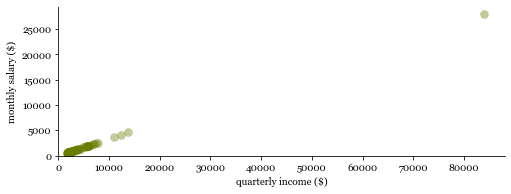

In [19]:

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.scatter(x[:, 0], x[:, 1], color=GREEN, alpha=0.4, s=74, linewidths=0)
ax.set_xlim(left=0); ax.set_ylim(bottom=0)
ax.set_ylabel('monthly salary ($)')
ax.set_xlabel('quarterly income ($)')
clean(ax)
ax.set_aspect('equal')

plt.savefig('income1.svg')


We introduce a small amount of noise to make the data only approximately linear.

In [11]:
xn = x.copy()

# 20 job changers
idx = np.random.randint(100, size=20)
p = 1 - np.random.rand(20) * 0.01
xn[idx, 1] = xn[idx, 1] * p + gen(20) * 3 * (1 - p)

# 25 bonus receivers
idx = np.random.randint(100, size=25)
xn[idx, 1] *= np.random.rand(25) * 0.5 + 1 

# 30 people with extra income
idx = np.random.randint(100, size=30)
xn[idx, 1] += gen(30) * 0.5


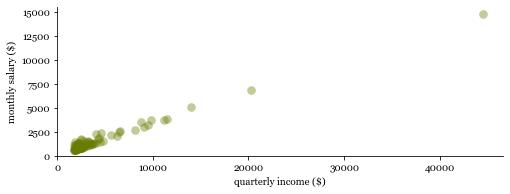

In [12]:

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.scatter(xn[:, 0], xn[:, 1], color=GREEN, alpha=0.4, s=74, linewidths=0)
ax.set_xlim(left=0); ax.set_ylim(bottom=0)
ax.set_ylabel('monthly salary ($)')
ax.set_xlabel('quarterly income ($)')
clean(ax)
ax.set_aspect('equal')


plt.savefig('income2.svg')


To apply PCA, we'll have to mean-center the data. We'll also plot it in axes with equal aspect, so we can recognize right angles (Notice how much the outliers throw off the centering).

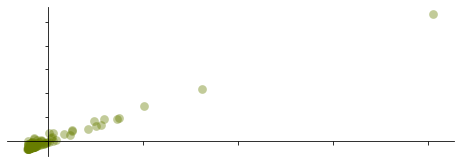

In [20]:
# Mean center
xm = xn - xn.mean(axis=0, keepdims=True)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.scatter(xm[:, 0], xm[:, 1], color=GREEN, alpha=0.4, s=76, linewidths=0)
ax.set_aspect('equal')
zero(ax)
ax.tick_params(labelbottom=False, labelleft=False)    
# plt.savefig('mean-centered.svg', transparent=True, bbox_inches='tight', pad_inches=0)


Now, let's pick an arbitrary line **w** to project onto, and let's see what kind of reconstructions we get.

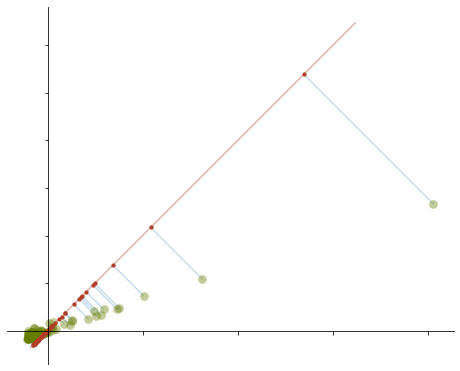

In [22]:

# Random point on the n-sphere: sample from a standard Gaussian, and project to a unit vector
# w = np.random.randn((2, 1)) # random

# Instead of a random w, we pick the diagonal
w = np.ones((2, 1)) # diagonal line
w /= la.norm(w)

# project to z 
z = np.matmul(xm, w)
# project back 
xp = z * w.T

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.scatter(xm[:, 0], xm[:, 1], color=GREEN, alpha=0.4, s=76, linewidths=0)
ax.set_aspect('equal')
zero(ax)
ax.tick_params(labelbottom=False, labelleft=False)  

ax.scatter(xp[:, 0], xp[:, 1], color=RED, alpha=1, s=18, linewidths=0)

mm = np.asarray([[z.min()], [z.max()]]) * 1.2
ls = mm * w.T
ax.plot(ls[:, 0], ls[:, 1], color=RED, alpha =0.4)

for i in range(xp.shape[0]):
    line = lines.Line2D([xm[i, 0], xp[i, 0]], [xm[i, 1], xp[i, 1]], color='#73a7d3', zorder=-1, alpha=0.4)
    ax.add_line(line)

# ax.set_xlim(x.min(), x.max()); ax.set_ylim(x.min(), x.max())

plt.savefig('random-w.svg', transparent=False, bbox_inches='tight', pad_inches=0)


Now, we'll search for the minimum by combining gradient descent with projection. Working out the gradient is a bit of pain, but this is what I came up with.

It's quite sensitive to learning rate. By using Adam as an optimizer (see below) we can check what the loss is we should be getting.

In [29]:
iterations, lr, mu = 5000, 0.001, 0.999

w, v = np.random.randn(2, 1), np.zeros((2, 1))
w /= la.norm(w)

ws = []

t = trange(iterations, desc='[loss: ]', leave=True)
for i in t:
    
    ws.append(w)
    
    l = np.matmul(xm, w) * w.T - xm # rec. distance per instance, feature
    grad = np.matmul(np.matmul(xm.T, l), w) + np.matmul(l.T, np.matmul(xm, w))
    
    v = mu * v - lr * grad
    w = w + v
    
    # project
    w /= la.norm(w)
    
    loss = (l ** 2).sum()
    t.set_description(f'[loss: {float(loss):.6}]')

    


[loss: 7.01572e+06]:  97%|█████████▋| 4841/5000 [00:04<00:00, 1237.77it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Alternatively, we can let pytorch do the work for us. We just need to add the projection step to the standard training loop.

In [24]:

# for lrexp in np.linspace(-8, 8, 100):

iterations, lr = 50_000, 0.00001

w = nn.Parameter(torch.randn(2, 1))

# opt = torch.optim.SGD(lr=lr, params=[w], momentum=0.9999, nesterov=False)
opt = torch.optim.Adam(lr=lr, params=[w])

w.data = w.data / w.data.norm()

ws = []
xmt = torch.from_numpy(xm.copy()).to(torch.float)

t = trange(iterations, desc='[loss: ]', leave=True)
for i in t:

    opt.zero_grad()

    loss = 0.5 * torch.mm(xmt, w) * w.t() - xmt # rec. distance per instance, feature
    loss = loss.pow(2).sum()

    loss.backward()
#     print(w.grad.data.t())
    opt.step()

    # project
    w.data = w.data / w.data.norm()
    
    ws.append(w.data.numpy())

    t.set_description(f'[loss: {loss.item():.6}]')


w = w.data.numpy()


[loss: 1.95597e+09]: 100%|██████████| 50000/50000 [01:14<00:00, 672.61it/s]


We can now plot the solution we found.

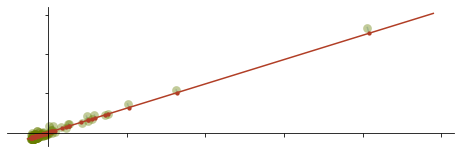

In [30]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.scatter(xm[:, 0], xm[:, 1], color=GREEN, alpha=0.4, s=76, linewidths=0)
ax.set_aspect('equal')
zero(ax)
ax.tick_params(labelbottom=False, labelleft=False)    

# project to z 
z = np.matmul(xm, w)
# project back 
xp = z * w.T

ax.scatter(xp[:, 0], xp[:, 1], color=RED, alpha=1, s=18, linewidths=0)

mm = np.asarray([[z.min()], [z.max()]]) * 1.2
ls = mm * w.T
ax.plot(ls[:, 0], ls[:, 1], color=RED, alpha=1)

# for wi in ws[::50]:
#     ls = mm * wi.T
#     ax.plot(ls[:, 0], ls[:, 1], color=RED, alpha=.01, zorder = -10)

for i in range(xp.shape[0]):
    line = lines.Line2D([xm[i, 0], xp[i, 0]], [xm[i, 1], xp[i, 1]], color='#73a7d3', zorder=-1, alpha=0.4)
    ax.add_line(line)

# ax.set_xlim(x.min(), x.max()); ax.set_ylim(x.min(), x.max())

plt.savefig('sol-w.svg', transparent=True, bbox_inches='tight', pad_inches=0)

Since we have a model with two parameters, we can plot the learning trajectory in parameter space. It should stay neatly on the unit circle.

(-1.0, 1.0)

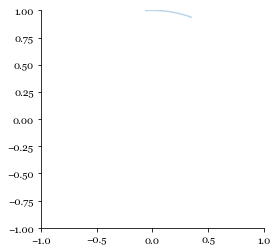

In [25]:
wsa = np.asarray(ws).squeeze()
wsa.shape

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)

ax.plot(wsa[:, 0], wsa[:, 1], linestyle='-', alpha = 0.3)
clean(ax)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)



### Deriving the second principal component

To derive the second principal component, we add a projection step for the constraint that it shoudl be orthogonal to the one we've already chosen.

In [31]:
iterations, lr, mu = 5000, 0.001, 0.999

w2, v = np.random.randn(2, 1), np.zeros((2, 1))
w2 /= la.norm(w2)

ws = []

t = trange(iterations, desc='[loss: ]', leave=True)
for i in t:
    
    ws.append(w2)
    
    # The gradient is the same, only the constraint changes
    l = np.matmul(xm, w) * w2.T - xm # rec. distance per instance, feature
    grad = np.matmul(np.matmul(xm.T, l), w) + np.matmul(l.T, np.matmul(xm, w))
    
    v = mu * v - lr * grad
    w2 = w2 + v
    
    
    # project to be orthogonal to w
    w2 = w2 - w * np.dot(w.T, w2)
    
    # project to unit vector
    w2 /= la.norm(w2)
    
    loss = (l ** 2).sum()
    t.set_description(f'[loss: {float(loss):.6}]')

[loss: 5.41784e+09]: 100%|██████████| 5000/5000 [00:04<00:00, 1057.23it/s]


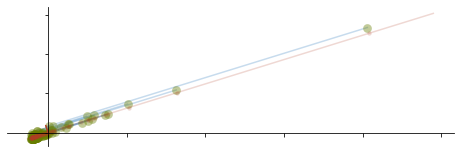

In [32]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.scatter(xm[:, 0], xm[:, 1], color=GREEN, alpha=0.4, s=76, linewidths=0)
ax.set_aspect('equal')
zero(ax)
ax.tick_params(labelbottom=False, labelleft=False)    


## First principal component
# project to z 
z = np.matmul(xm, w)
# project back 
xp = z * w.T

ax.scatter(xp[:, 0], xp[:, 1], color=RED, alpha=0.2, s=18, linewidths=0)

mm = np.asarray([[z.min()], [z.max()]]) * 1.2
ls = mm * w.T
ax.plot(ls[:, 0], ls[:, 1], color=RED, alpha=0.2)

## Second principal component
# project to z 
z = np.matmul(xm, w2)
# project back 
xp = z * w2.T

mm = np.asarray([[z.min()], [z.max()]]) * 1.2
ls = mm * w2.T
ax.plot(ls[:, 0], ls[:, 1], color=RED, alpha=1)

# for wi in ws[::50]:
#     ls = mm * wi.T
#     ax.plot(ls[:, 0], ls[:, 1], color=RED, alpha=.01, zorder = -10)

for i in range(xp.shape[0]):
    line = lines.Line2D([xm[i, 0], xp[i, 0]], [xm[i, 1], xp[i, 1]], color='#73a7d3', zorder=-1, alpha=0.4)
    ax.add_line(line)

# ax.set_xlim(x.min(), x.max()); ax.set_ylim(x.min(), x.max())

plt.savefig('sol-w2.svg', transparent=True, bbox_inches='tight', pad_inches=0)

### Second example: faces

We use the Olivetti dataset, a set of 400 grayscale 64x64 pixel images of faces. The lighting is uniform and the facial features are generally well-aligned. In other words, this is an easy dataset for face recognition, but it isn't very big.

In [33]:
from sklearn import datasets
faces = datasets.fetch_olivetti_faces()
faces.data.shape

(400, 4096)

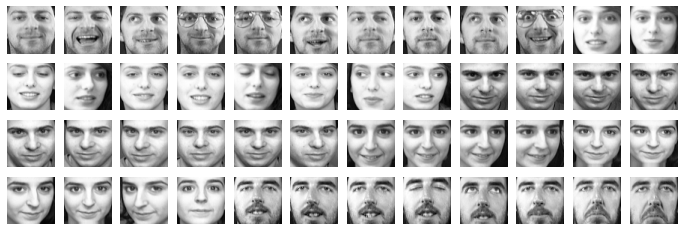

In [34]:
c, r = 12, 4

# plot several images
fig = plt.figure(figsize=(c, r))

offset = 60
for i in range(c*r):
    ax = fig.add_subplot(r, c, i + 1, xticks=[], yticks=[])
    ax.imshow(faces.images[i+offset], cmap=plt.cm.gray)
    ca(ax)
    
plt.savefig('faces.png')

In [35]:
# Learn the first principal component by minimizing the 
# sum of squared  errors on the reconstruction

iterations = 250
# preprocessing

x = torch.from_numpy(faces.data).contiguous()

# Mean-center the data
xmean = x.mean(dim=0, keepdim=True)
x = x - xmean
nfeatures = x.size(1)

weights = nn.Parameter(torch.randn(nfeatures, 1))

opt = SGD(lr=0.0001, params=[weights])
# -- this example seems a little less sensitive, no momentum needed here

t = trange(iterations, desc='[loss: ]', leave=True)
for _ in t:
    opt.zero_grad()

    z = torch.mm(x, weights)
    rec = torch.mm(z, weights.t())

    loss = (x - rec).pow(2).sum()

    loss.backward()
    opt.step()

    t.set_description(f'[loss: {float(loss.item()):.6}]')

    # projection: make the weights into a unit vector
    weights.data = weights.data / weights.data.norm(dim=0)
    
components = weights

[loss: 24050.8]: 100%|██████████| 250/250 [00:02<00:00, 91.26it/s]


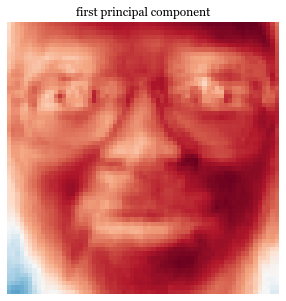

In [36]:
# plot the principal component in image space

fig, ax1= plt.subplots(1, 1, figsize=(5, 5))

pc = weights.data.view(64, 64).numpy()
mabs = np.abs(pc).max()

norm = mpl.colors.Normalize(vmin=-mabs, vmax=mabs)

im = ax1.imshow(pc, cmap='RdBu', norm=norm)
ax1.set_title('first principal component')
ca()

plt.savefig('firstpc.svg')

We can see how much of the original image remains in the reconstructions. The results aren't exactly mindblowing, but then we have summarized each face into a _single_ number.

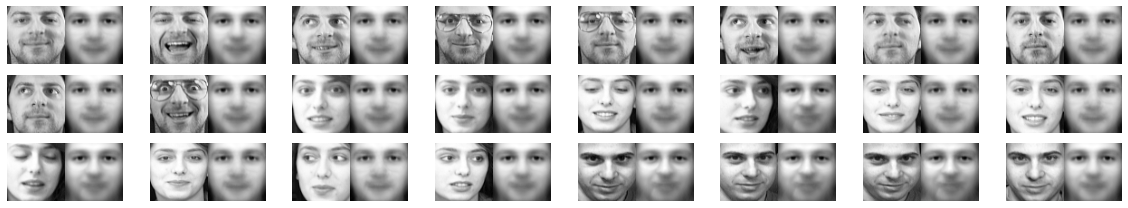

In [37]:
rec = torch.mm(torch.mm(x, components), components.t()) + xmean
rec = rec.detach().view(400, 64, 64).numpy()

c, r = 8, 3
offset = 60

# plot several images
fig = plt.figure(figsize=(c*2, r))

for i in range(c*r):
    ax = fig.add_subplot(r, c, i + 1)

    ax.imshow(faces.images[i+offset], cmap=plt.cm.gray, extent=(0, 1, 0, 1))
    ax.imshow(rec[i+offset], cmap=plt.cm.gray, extent=(1, 2, 0, 1))

    ax.set_xlim(0, 2)
    ax.set_ylim(0, 1)

    ca(ax)

fig.tight_layout()
plt.savefig(f'face-reconstructions.png', transparent=True, bbox_inches='tight', pad_inches=0)

What's more interesting is what the principal component tells us about our data. To visualize this, we can take some face, let's say the mean face, encode it to the latent space, and see what's to the left and to the right of it. In other words, the PCA has transformed the dat into a space with only to directions to move. Let's see if we can visualize what these directions mean.

Since everything is linear, we can just take the principal component itself and add a negative or positive multiple of it to the mean face.

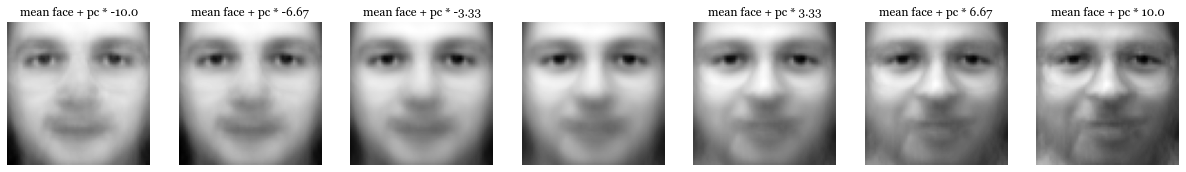

In [38]:
# plot the effect of the first principal component on the mean face

num, b = 7, 10.0
fig, axes = plt.subplots(1, num, figsize=(num*3, 3))

pc = weights.data.view(64, 64).numpy()
meanface = faces.data.mean(axis=0).reshape(64, 64)

for i, (mult, ax) in enumerate(zip(np.linspace(-b, b, num=num), axes)):
    ax.imshow(meanface + mult * pc, cmap='gray')
    if i != num//2:
        ax.set_title(f'mean face + pc * {mult:.3}')
    ca(ax)
    
# fig.tight_layout()
# plt.subplots_adjust(left=-0.5, right=0.5)
plt.savefig('int-mean-face.svg', transparent=True, bbox_inches='tight', pad_inches=0)

There are a couple of things happenign at once, but basically, the result seems to be that in one direction the face gets younger (more even, lighter skin, no glasses) and in the other the face gets older (more pronounced glasses, wrinkles, skin blemishes, etc).

The effect becomes easier to read if we start with a face from the dataset, and apply a multiple of the PC.

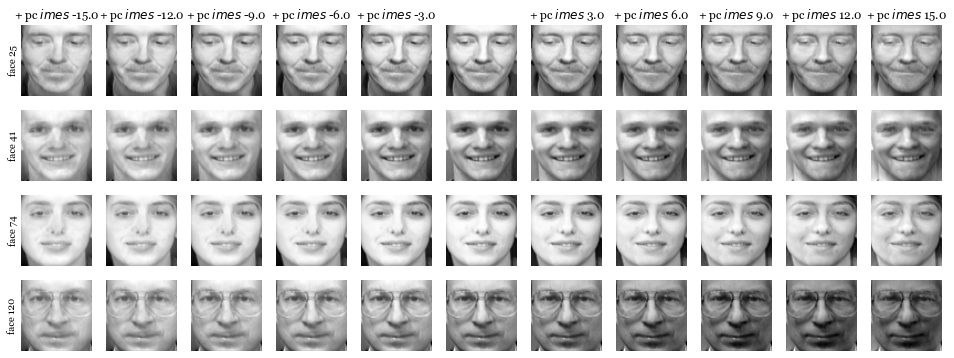

In [39]:
# plot the effect of the first principal component on some data faces

fs = 25, 41, 74, 120

num, b = 11, 15.0
fig, axes = plt.subplots(len(fs), num, figsize=(num*1.5, len(fs)*1.5))

pc = weights.data.view(64, 64).numpy()

for i, (f, axrow) in enumerate(zip(fs, axes)):
    face = faces.images[f]
    for j, (mult, ax) in enumerate(zip(np.linspace(-b, b, num=num), axrow)):
        ax.imshow(face + mult * pc, cmap='gray')
#         ax.set_title(f'face {f} + pc * {mult:.3}')
        if i ==0 and j != num//2:
            ax.set_title(f'+ pc $\times$ {mult:.3}')
        if j == 0:
            ax.set_ylabel(f'face {f}')
        ca(ax)
        
plt.savefig('int-data-faces.svg', transparent=True, bbox_inches='tight', pad_inches=0)

We can also sort the data by the first PC. There seems to be a rough correlation with age, but perhaps it's more accurate to say that the first PC captures the derkness of the skin (either due to skin color or amount of shadow cast bu wrinkles and other features).

[ 35  58 155 328 164 226 106  83 359   4 215 123]
[ 1  9  0  8  4  6 11  7  2  5  3 10]


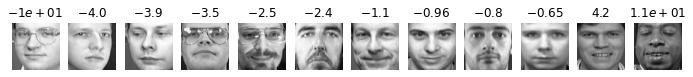

In [41]:
# Sort some of the data by the first PC

zs = torch.mm(x, components).data.numpy().squeeze()

N = 12

idx = np.random.randint(400, size=N)
print(idx)

sample = faces.images[idx]
zs = zs[idx]

sidx = np.argsort(zs)
print(sidx)

zs = zs[sidx]
sample = sample[sidx]

fig, axes = plt.subplots(1, N, figsize=(N, 1))

for i, ax in enumerate(axes):
    
    ax.set_title(f'${zs[i]:.2}$')
    ax.imshow(sample[i], cmap='gray')
    ca(ax)

To learn additional PCs, we follow the same iterative approach as before: we constrain the second PC to be orthogonal to the first.

In [46]:
# Learn components iteratively

iterations = 1500 # 250 is fine for the first few eigenvectors
k = 5 # this should be enough for decent reconstructions
# preprocessing

x = torch.from_numpy(faces.data).contiguous()

xmean = x.mean(dim=0, keepdim=True)
x = x - xmean
nfeatures = x.size(1)

components = None

for ki in range(k):

    # solve PCA by gradient descent
    weights = nn.Parameter(torch.randn(nfeatures, 1))

    opt = SGD(lr=0.0001, params=[weights])

    t = trange(iterations, desc='[loss: ]', leave=True)
    for _ in t:
        opt.zero_grad()

        z = torch.mm(x, weights)
        rec = torch.mm(z, weights.t())

        loss = (x - rec).pow(2).sum()

        loss.backward()
        opt.step()

        t.set_description(f'[{ki:03} loss: {float(loss.item()):.6}]')
        
        # projections
        # -- make orthogonal to known components
        for i in range(ki):
            z = components[:, i:i+1]
            w = weights.data
            weights.data = w - z * (torch.mm(z.t(), w) / torch.mm(z.t(), z))
        
        # -- make a unit vector
        weights.data = weights.data / weights.data.norm(dim=0)

    # add the principal component
    components = weights.data if components is None else torch.cat([components, weights.data], dim=1)

    
with torch.no_grad():
    z = torch.mm(x, components)
    rec = torch.mm(z, components.t())
    
    print('sum of squares', (x - rec).pow(2).sum().item())

[004 loss: 30428.4]: 100%|██████████| 1500/1500 [00:17<00:00, 85.88it/s]


sum of squares 14400.16015625


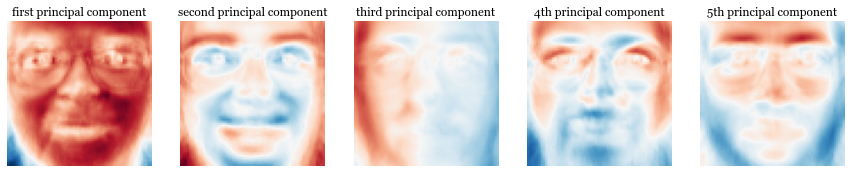

In [60]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 3))


mabs = np.abs(components.detach().numpy()).max()    
norm = mpl.colors.Normalize(vmin=-mabs, vmax=mabs) # normalize symmetrically to put 0 at white

ax1.imshow(components.detach()[:, 0].view(64, 64).numpy(), cmap='RdBu')
ax1.set_title('first principal component')
ca(ax1)

if components.size(1) > 0:
    ax2.imshow(components.detach()[:, 1].view(64, 64).numpy(), cmap='RdBu', norm=norm)
    ax2.set_title('second principal component')
    ca(ax2)
    
if components.size(1) > 1:
    ax3.imshow(components.detach()[:, 2].view(64, 64).numpy(), cmap='RdBu', norm=norm)
    ax3.set_title('third principal component')
    ca(ax3)
    
if components.size(1) > 2:
    ax4.imshow(components.detach()[:, 3].view(64, 64).numpy(), cmap='RdBu', norm=norm)
    ax4.set_title('4th principal component')
    ca(ax4)

if components.size(1) > 3:
    ax5.imshow(components.detach()[:, 4].view(64, 64).numpy(), cmap='RdBu', norm=norm)
    ax5.set_title('5th principal component')    
    ca(ax5)
    
plt.savefig('five-pcs.svg', transparent=True, bbox_inches='tight', pad_inches=0)

Plotting the reconstructions

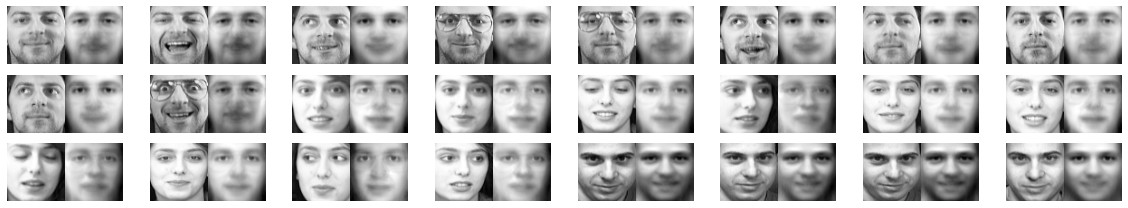

In [48]:
rec = torch.mm(torch.mm(x, components), components.t()) + xmean
rec = rec.detach().view(400, 64, 64).numpy()

c, r = 8, 3
offset = 60

# plot several images
fig = plt.figure(figsize=(c*2, r))

for i in range(c*r):
    ax = fig.add_subplot(r, c, i + 1)

    ax.imshow(faces.images[i+offset], cmap=plt.cm.gray, extent=(0, 1, 0, 1))
    ax.imshow(rec[i+offset], cmap=plt.cm.gray, extent=(1, 2, 0, 1))

    ax.set_xlim(0, 2)
    ax.set_ylim(0, 1)

    ca(ax)

fig.tight_layout()
plt.savefig(f'face-reconstructions-k5.png', transparent=True, bbox_inches='tight', pad_inches=0)

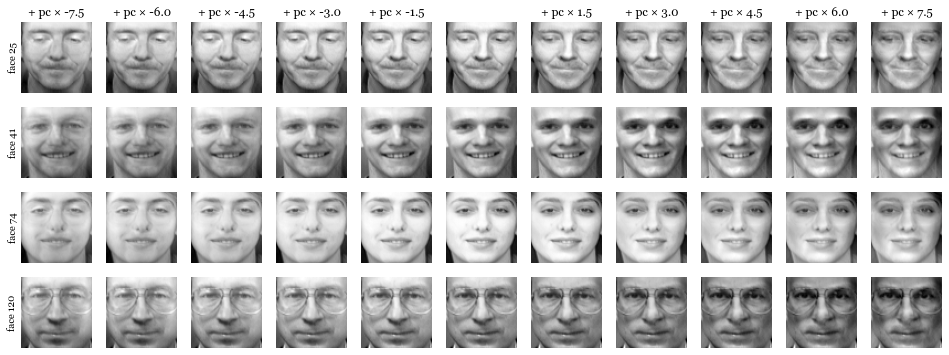

In [49]:
# plot the effect of the n-th principal component on some data faces
COMP = 3

fs = 25, 41, 74, 120

num, b = 11, 7.5
fig, axes = plt.subplots(len(fs), num, figsize=(num*1.5, len(fs)*1.5))

pc = components[:, COMP].data.view(64, 64).numpy()

for i, (f, axrow) in enumerate(zip(fs, axes)):
    face = faces.images[f]
    for j, (mult, ax) in enumerate(zip(np.linspace(-b, b, num=num), axrow)):
        ax.imshow(face + mult * pc, cmap='gray')
#         ax.set_title(f'face {f} + pc * {mult:.3}')
        if i ==0 and j != num//2:
            ax.set_title(f'+ pc × {mult:.3}')
        if j == 0:
            ax.set_ylabel(f'face {f}')
        ca(ax)
        
plt.savefig(f'int-data-faces-pc{COMP}.svg', transparent=True, bbox_inches='tight', pad_inches=0)

To show that the combined approach can result in fundamentally different PCs, we need to proceed carefully. If we do projected gradient descent here, for instance using Gram-Schmidt to project W to an orthogonal matrix, we tend to converge to something similar the PCA solution, even if it is not strictly required (see the commented out code).

Instead, we use gradient ascent/descent. We define a Lagrangian and ascend wrt to the lagrange multipliers, and descend wrt to the other parameters. See **Constrained Differential Optimization**, Platt and Barr (1988) for a description of the method.

This method takes a while to converge, so it's not a practical way to solve the problem, but it helps us to illustrate the difference between the iterative and combined problems. 

The second loss should get close to zero, and the sum of squares should be close similar to the value we got in the iterative version. (This cell doesn't always terminate when the loop finishes, so you may need to kill it.)

In [98]:
# Learn components in one go

C = 0.1 # damping parameter

iterations = 50_000
k = 5
# preprocessing

x = torch.from_numpy(faces.images).contiguous()
x = x.view(400, -1)

xmean = x.mean(dim=0, keepdim=True)
x = x - xmean
nfeatures = x.size(1)

# solve PCA by gradient descent
weightsc = nn.Parameter(torch.randn(nfeatures, k))
mults = nn.Parameter(torch.ones(k, k))

ti = torch.triu_indices(k, k)

lr = 0.05
opt1 = Adam(lr=lr, params=[weightsc])
opt2 = Adam(lr=lr, params=[mults])

const = lambda m, w : (m[ti] * (torch.mm(w.t(), w)[ti] - torch.eye(k)[ti])).abs().sum()

t = trange(iterations, leave=True)
for _ in t:
    
    opt1.zero_grad(); 

    z = torch.mm(x, weightsc)
    rec = torch.mm(z, weightsc.t())
    
    # gradient descent on the lagrangian wrt the weights
    loss1 = (x - rec).pow(2).sum() + const(mults, weights) 
    
    loss1 = loss1 + (C/2) * (torch.mm(weightsc.t(), weightsc)[ti] - torch.eye(k)[ti]).pow(2.0).sum() 
    # -- squared penalty term (helps to damp oscillations and speed up convergence
    
    loss1.backward()
    opt1.step()
    
    opt2.zero_grad()
    
    # gradient ascent wrt the lambdas (first term is contant, so we remove it)
    loss2 = - const(mults, weightsc)
    loss2.backward()
    opt2.step() 

    t.set_description(f'[loss: {float(loss1.item()):.3} {float(loss2.item()):.3} {(x - rec).pow(2).sum():.3}]')

#     # -- make orthogonal (gram schmidt)
#     for i in range(wd.size(1)):

#         z = wd[:, :i] # subspace to exclude
#         mult = (z * wd[:, i:i+1]).sum(dim=0, keepdim=True) / (z*z).sum(dim=0, keepdim=True)
#         wd[:, i] = wd[:, i] - (z * mult).sum(dim=1)

    # -- make unit vectors
#     wd = weights.data
#     wd = wd / wd.norm(dim=0)
#     weights.data = wd

print(torch.mm(weightsc.t(), weightsc).detach().numpy().round(4))

with torch.no_grad():
    z = torch.mm(x, weightsc)
    rec = torch.mm(z, weightsc.t())
    
    print('sum of squares', (x - rec).pow(2).sum())
    
components = weightsc.data

# components.size(1)



[loss: 3.85e+04 -0.00155 1.44e+04]: 100%|█████████▉| 49997/50000 [13:56<00:00, 59.61it/s] 

KeyboardInterrupt: 

Note that the sum of squares finishes at 1.44e+04, same as we got for the iterated problem, and that the second loss finishes near 0 (-0.00155 in my run), so we know the constraints are pretty well satisfied.

Plotting the solutions to this problem, we see that we do not get the PCs we we got above.

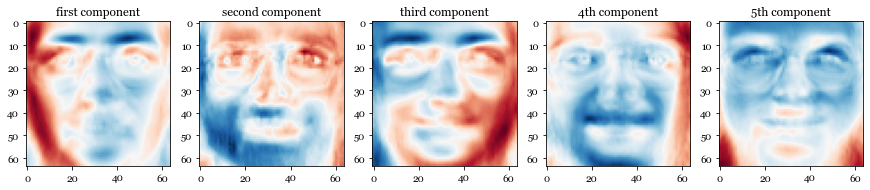

In [101]:
components = weightsc.data
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 3))

ax1.imshow(components.detach()[:, 0].view(64, 64).numpy(), cmap='RdBu')
ax1.set_title('first component')

if components.size(1) > 0:
    ax2.imshow(components.detach()[:, 1].view(64, 64).numpy(), cmap='RdBu')
    ax2.set_title('second component')
    
if components.size(1) > 1:
    ax3.imshow(components.detach()[:, 2].view(64, 64).numpy(), cmap='RdBu')
    ax3.set_title('third component')
    
if components.size(1) > 2:
    ax4.imshow(components.detach()[:, 3].view(64, 64).numpy(), cmap='RdBu')
    ax4.set_title('4th component')

if components.size(1) > 3:
    ax5.imshow(components.detach()[:, 4].view(64, 64).numpy(), cmap='RdBu')
    ax5.set_title('5th component') 

Text(0.5, 1.0, 'second principal component')

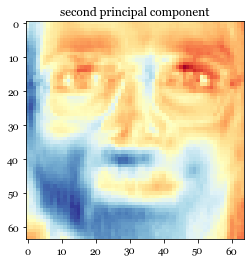

In [102]:
plt.imshow(components.detach()[:, 1].view(64, 64).numpy(), cmap='RdYlBu')
plt.title('second principal component')

The reconstructions, however should be pretty similar to those we got for the iterative approach. In the second part, we will learn that this is because while the individidual components are different, they span the same space as the first five principal components.

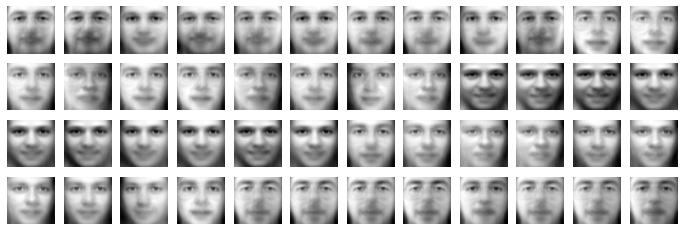

In [104]:
rec = torch.mm(torch.mm(x, components), components.t()) + xmean
rec = rec.detach().view(400, 64, 64).numpy()

c, r = 12, 4

# plot several images
fig = plt.figure(figsize=(c, r))

offset = 60
for i in range(c*r):
    ax = fig.add_subplot(r, c, i + 1, xticks=[], yticks=[])
    ax.imshow(rec[i+offset], cmap=plt.cm.gray)
    ca(ax)
    
plt.savefig('faces.png')

As a sanity check, we can use a proper SVD implementation like the one that comes with sklearn, to check that what the iterative method gave us were indeed the principal components.

(10, 4096)


Text(0.5, 1.0, 'first principal component')

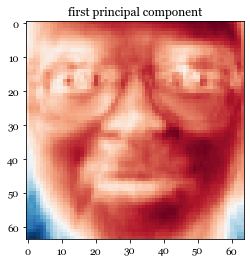

In [106]:
# Using the sklearn PCA implementation
x = faces.images.reshape(400, -1)
k = 10

pca = PCA(k, svd_solver='randomized',
          whiten=True).fit(x)
    
eigenfaces = pca.components_

print(eigenfaces.shape)

plt.imshow(eigenfaces[0].reshape(64, 64), cmap='RdBu')
plt.title('first principal component')

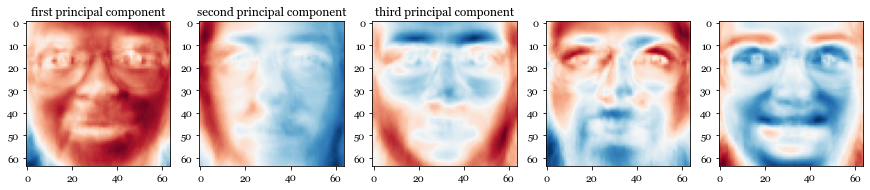

In [107]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 3))

ax1.imshow(eigenfaces[0].reshape(64, 64), cmap='RdBu')
ax1.set_title('first principal component')

ax2.imshow(eigenfaces[1].reshape(64, 64), cmap='RdBu')
ax2.set_title('second principal component')
    
ax3.imshow(eigenfaces[2].reshape(64, 64), cmap='RdBu')
ax3.set_title('third principal component')

ax4.imshow(eigenfaces[3].reshape(64, 64), cmap='RdBu')
ax5.imshow(eigenfaces[4].reshape(64, 64), cmap='RdBu')


Another sanity check: the sum of all squared variances in all directions under the standard basis should equal the sum of all squared variances under a complete PCA (this is discussed in the second part).

In [112]:
x = faces.data - faces.data.mean(axis=0)

standard = (1/x.shape[0]) * (x ** 2).sum()

# ks = [1, 2, 3, 4, 5, 10, 25, 50, 100, 150, 300, 350, 400]
ks = list(range(1, 401))
vs = []

for k in tqdm(ks):

    pca = PCA(k, svd_solver='auto', whiten=True).fit(x)
    var = 0
    for c in pca.components_:
        var += (np.dot(x, c) ** 2).sum()
    vs.append(var/x.shape[0])

100%|██████████| 400/400 [01:02<00:00,  4.26it/s]

KeyboardInterrupt: 

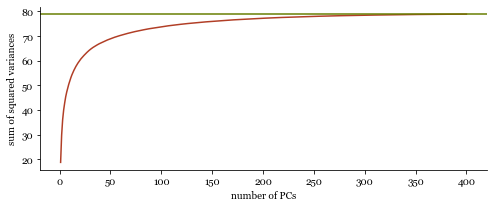

In [113]:
plt.figure(figsize=(8, 3))

plt.plot(ks, vs, color=RED)
plt.axhline(standard, color=GREEN)

plt.xlabel('number of PCs')
plt.ylabel('sum of squared variances')

clean()

plt.savefig('sum-variance.svg',transparent=True, bbox_inches='tight', pad_inches=0)